<a href="https://colab.research.google.com/github/ThunderWiring/learning-computer-vision/blob/main/panorama_stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [270]:
import numpy as np
import cv2
from skimage import io
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import requests
from google.colab import drive
import sys

# Preparing images to stitch

The end goal of this notebook is to understand image stitching and what it conveys: features, descriptors, stitching (homography transform), ..etc.

Also, will take advantage of the type of images i was able to find online, and use opencv functions and methods to extract the images to stitch together.

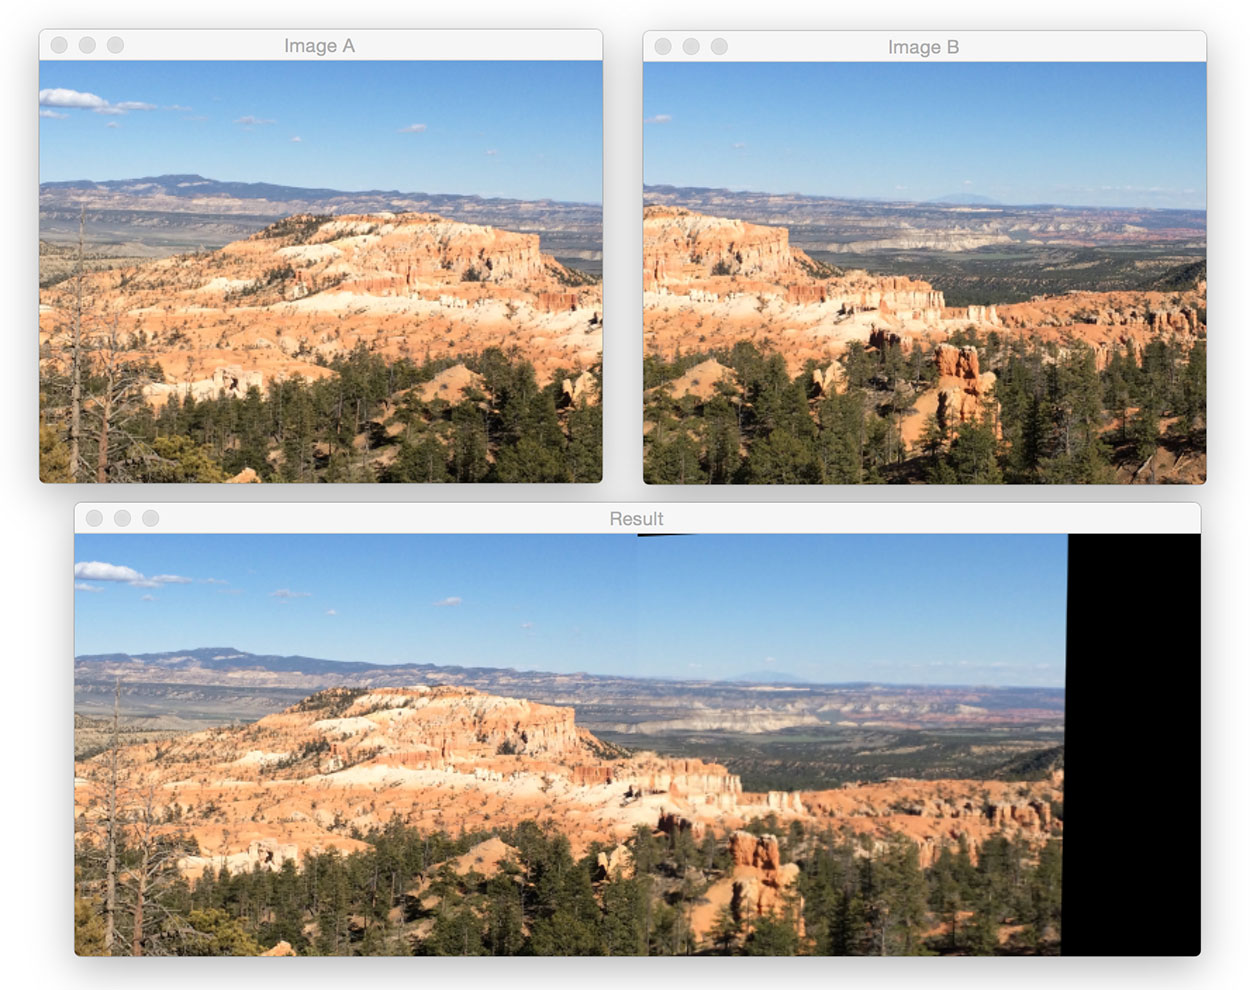

In [271]:
# NOTE: Not all image URLs work, for example the following url didnt:
# https://www.australiangeographic.com.au/wp-content/uploads/2018/06/PanoramaCells-1000px.jpg

url = 'https://pyimagesearch.com/wp-content/uploads/2016/01/bryce_result_02.jpg'
images_grid = io.imread(url)
gray_grid = cv2.cvtColor(images_grid, cv2.COLOR_BGR2GRAY)
cv2_imshow(cv2.cvtColor(images_grid, cv2.COLOR_BGR2RGB))

Need to extract the 6 small images in order to apply the stitching algo on them.
For this, i need to find the bounding box coordinates of each image.

One way to do this is to make all the pixels in the background one color (i.e. black) , and the rest another (white). Therefore, need to know which color is the background in order to determin the threshhold. To know this, will create a histogram of the pixel intensities of `gray_grid`

threshhold 135.0


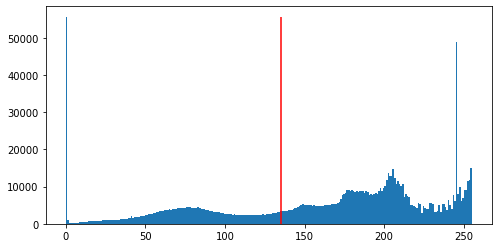

In [272]:
thr, im_bw = cv2.threshold(gray_grid, 0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print('threshhold', thr)
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
counts, bins, _ = ax.hist(gray_grid.ravel(), bins=256)
ax.vlines(x=th, ymin=0,ymax=np.max(counts),color='red')

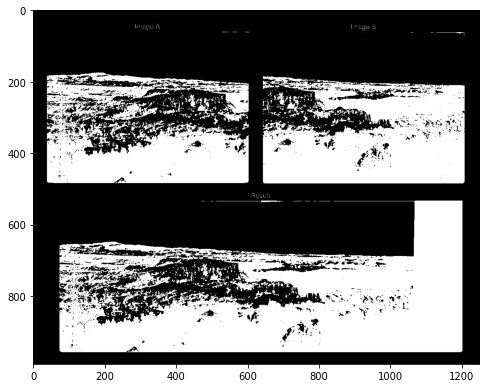

In [273]:
bw = gray_grid < 166
bw = bw.astype(np.uint8)
plt.figure(figsize=(8,8))
plt.imshow(bw, cmap='gray')

To extract the images, i need to find the bounding boxes around the white blobs above.

number of CCs 1262


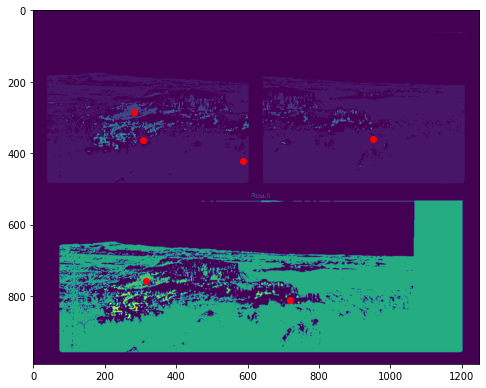

In [274]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(bw)
labels,stats
print('number of CCs', retval)
max_area = 10_00
valid_inds = [idx for idx, s in enumerate(stats) if s[4] > max_area]
centers = centroids[valid_inds]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(labels)
ax.scatter(x=centers[:,0], y=centers[:, 1], color='red')


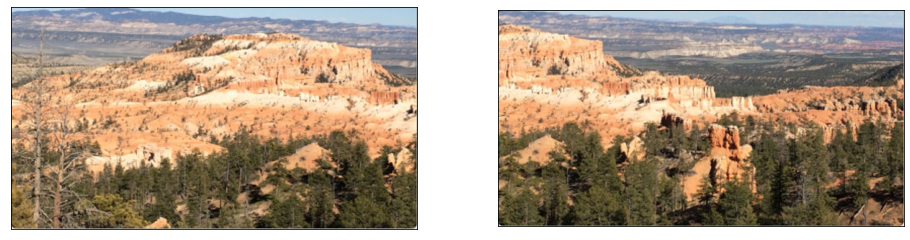

In [275]:
# array containing the top-left and bottom-right coords of the bounding boxes
bounding_rects = [
                    [
                     [s[cv2.CC_STAT_LEFT], s[cv2.CC_STAT_TOP]], # top-left vertex
                     [s[cv2.CC_STAT_LEFT] + s[cv2.CC_STAT_WIDTH], s[cv2.CC_STAT_TOP] + s[cv2.CC_STAT_HEIGHT]]
                    ] 
                  for s in stats[valid_inds]
                ]
images = [images_grid[v[0][1]:v[1][1], v[0][0]:v[1][0] ] for v in bounding_rects]

# taking the images that matter:
images = images[1:3]
num_images = len(images)

fig = plt.figure(figsize=(8*num_images,8))
for ind, img in enumerate(images):
  plt.subplot(1, num_images, ind+1)
  plt.imshow(img, cmap='gray')
  plt.xticks([]) # removing axis numbers
  plt.yticks([]) # removing axis numbers


Not bad at all! Finally i can stitch them together

# Stitching

For each image:
1. Find the features and their descriptors (using ORB/ SIFT)
1. Filter out unstable features (using knn)

init: stitched image <== 1st image
For each image:
 1. find the homography matrix with the stitched image so far - H.
 2. transform the image using H
 3. fill the new stitched image with the trasformed image from prev step
 4. fill the stitched image into the new-stitched image
 5. stitched image <== new stitched image from step 4.


## Visualizing Keypoints

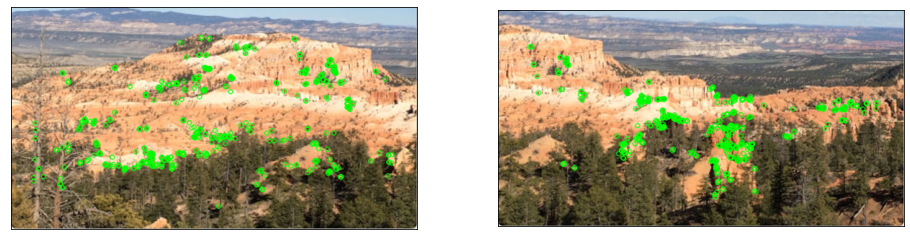

In [276]:
img_w_kpts = []
for img in images:
  kpts, _ = detector.detectAndCompute(img, None)
  img_w_kpts += [cv2.drawKeypoints(img, kpts, None, color=(0,255,0), flags=0)]

num_images = len(img_w_kpts)
fig = plt.figure(figsize=(8*num_images,8))
for ind, img in enumerate(img_w_kpts):
  plt.subplot(1, num_images, ind+1)
  plt.imshow(img, cmap='gray')
  plt.xticks([]) # removing axis numbers
  plt.yticks([]) # removing axis numbers


## Matching features

In [284]:
def stitch_images(img1, img2, H):
  rows1, cols1 = img1.shape[:2] # ignore channels
  rows2, cols2 = img2.shape[:2] # ignore channels
  img1_corners = np.float32([ 
                             [0,     0    ], 
                             [0,     rows1], 
                             [cols1, rows1], 
                             [cols1, 0    ]
                            ]).reshape(-1,1,2)                         
  img2_corners = np.float32([
                             [0,     0    ], 
                             [0,     rows2], 
                             [cols2, rows2], 
                             [cols2, 0    ] 
                            ]).reshape(-1,1,2)

  img2_corners_warped = cv2.perspectiveTransform(img2_corners, H)
  all_corners = np.concatenate((img1_corners, img2_corners_warped), axis=0)
  [x_min, y_min] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

  translation_dist = [-x_min, -y_min]
  H_translation = np.array(
      [
        [1   ,0   ,translation_dist[0]],
        [0   ,1   ,translation_dist[1]],
        [0   ,0   ,1] 
      ])
  
  # this call fills the transformed image (img2) into the output image.
  stitched = cv2.warpPerspective(
      img2, H_translation.dot(H), 
      dsize=(x_max-x_min, y_max-y_min) # size of output image
    )
  
  # this call fills the other image into the output
  stitched[
           translation_dist[1]:rows1+translation_dist[1], 
           translation_dist[0]:cols1+translation_dist[0]
          ] = img1
  return stitched

found matches: 22


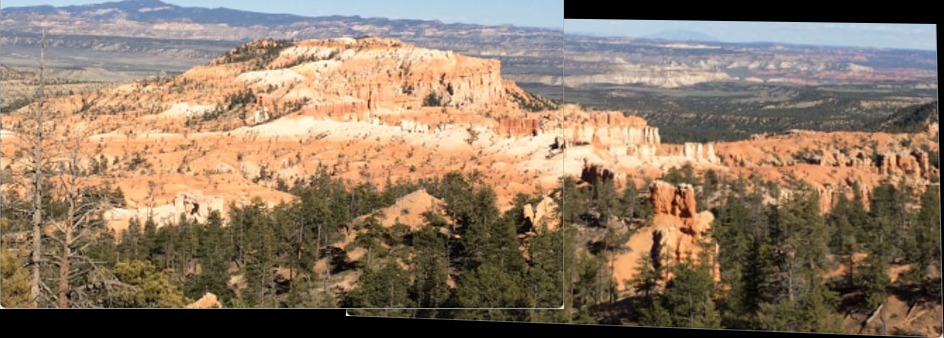

In [286]:

MIN_MATCH_COUNT = 10

# wanted to use SIFT but its not included in colab (some warning about it being patented..)
detector = cv2.ORB_create() 
matcher =	cv2.BFMatcher(cv2.NORM_L2)

stitched = images[0]
for ind in range(1, len(images)): # skipping first image as it's assigned to stitched
  img1 = cv2.cvtColor(stitched, cv2.COLOR_BGR2GRAY)
  img2 = cv2.cvtColor(images[ind], cv2.COLOR_BGR2GRAY)
  
  kpts1, descs1 = detector.detectAndCompute(img1, None)
  kpts2, descs2 = detector.detectAndCompute(img2, None)

  # Calculate the matches between descriptors.
  # Using KNN in order to discard weak/unstable matches, where for each descriptor
  # the function returns the closest 2 matched descriptors, and the closest one will
  # be taken if the 2nd one was too far from it (using L2 dist). That way we dont take 
  # a feature where many other features are similar to it, thus ensuring taking
  # robust/identifying features.
  matches = matcher.knnMatch(descs1, descs2, k=2, mask=None)
  good_matches = []
  for n,m in matches:
    if n.distance <= 0.7 * m.distance:
      good_matches.append(m)
  
  # sort matches by dist so we can take the closest X matches:
  matches = good_matches # sorted(good_matches, key=lambda x:x.distance)
  print('found matches:', len(matches))

  # compute homography and stitch
  if len(matches) >= MIN_MATCH_COUNT:
    src_pts = np.float32([kpts1[m.queryIdx].pt for m in matches])
    dst_pts = np.float32([kpts2[m.trainIdx].pt for m in matches])

    H, _mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 8)
    if H is not None:
      stitched = stitch_images(stitched, images[ind], np.linalg.inv(H))

cv2_imshow(cv2.cvtColor(stitched, cv2.COLOR_BGR2RGB))

## Notes

* This is relatevly a simple example, because there are only 2 images. i tried using [this image](https://more4u2c.files.wordpress.com/2010/11/panorama-illustration.jpg) which is made up from 6 images, but the stitching failed because there were not enough descriptors to match against (between 0-3).
  *  The reason the image above didn't work, is because the small images were too small, thus distorted enough to not find meaningful features.
* The reason there is an artifact in the final result (white lines) is because the cropping has some white padding to it. One way to overcome this is cropping the images, but when i tried that, the detector detected MUCH LESS features and the stitching failed. Not sure yet why this happens.
